In [1]:
# Uncomment below if running NB in Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


# General Imports
import os 
import numpy as np
import pandas as pd
import time
from dask import dataframe as dd


# Filenames/Categories for Files in Amazon Data Dir
data_files = ['All_Beauty.csv', 'Appliances.csv', 'Arts_Crafts_and_Sewing.csv', 'Automotive.csv', 'Books.csv', 'CDs_and_Vinyl.csv'
            , 'Cell_Phones_and_Accessories.csv', 'Clothing_Shoes_and_Jewelry.csv', 'Digital_Music.csv', 'Electronics.csv'
            , 'Gift_Cards.csv', 'Grocery_and_Gourmet_Food.csv', 'Home_and_Kitchen.csv', 'Industrial_and_Scientific.csv'
            , 'Kindle_Store.csv', 'Magazine_Subscriptions.csv', 'Luxury_Beauty.csv', 'Movies_and_TV.csv', 'Musical_Instruments.csv'
            , 'Office_Products.csv', 'Patio_Lawn_and_Garden.csv', 'Pet_Supplies.csv', 'Prime_Pantry.csv', 'Software.csv'
            , 'Sports_and_Outdoors.csv', 'Tools_and_Home_Improvement.csv', 'Toys_and_Games.csv', 'Video_Games.csv', 'Fashion.csv']
    #29 Product Categories in Total

# Currently config for CKG's Path, add new user paths below
#amz_dir_path = "/content/drive/MyDrive/Gini Spectral Fourier Data Quality project/Amazon Reviews - CKG/" #drive path
amz_dir_path = "/Volumes/GoogleDrive/.shortcut-targets-by-id/1HK4IIdQ8uwDV5XhlWPEB0s6mbi3Ai9Pl/Gini Spectral Fourier Data Quality project/Amazon Reviews - CKG/" #local path


# cd to Amazon Directory
os.chdir(amz_dir_path)
os.listdir()

['FetchData.ipynb',
 'Data',
 'AmazonData-EDA.ipynb',
 'FFT-Notes.ipynb',
 'Amazon_Reviews.csv',
 '.DS_Store',
 'GiniCalculation.ipynb',
 'Ratings.csv',
 'ProductCategory.csv']

**Notes**

After aggregated the data (based on the ProductCategory & Ratings for each date), we were able to cut down on the file size of the RAW data drastically, now both dataframes should fit into memory and work with Pandas



*Original Dataset*

[Amazon_Reviews.csv]() dims = (203,334,833 x 3) @ 6.94 GB

<BR>


[Ratings.csv]() dims = (3,288 x 3) @ 330 KB -- Cols = [datetime, rating, count] 
- datetime = date of ratings
- rating = what rating was given (1 to 5 stars)
- count_rating = count of that category of rating given for that date


[Product_Categories.csv]() dims = (3,288 x 3) @ 3.9 MB -- Cols = [datetime, product_category, count]    
- datetime = date of ratings
- product_category = which of the 29 categories that product belonged to
- count = count of that number of ratings that category recieved for the date

In [2]:
# Read in `Ratings.csv`

ratings_csv = os.path.join(amz_dir_path, "Ratings.csv")
df_ratings = pd.read_csv(ratings_csv, dtype={'rating': 'str', 'datetime':'str', 'count':'int'}, parse_dates=['datetime']) #may need to specify column dtype with dict like so
df_ratings

,datetime,rating,count
0,2009-03-11,5.0,3934
1,2009-03-11,4.0,1419
2,2009-03-11,3.0,606
3,2009-03-11,1.0,567
4,2009-03-11,2.0,355
...,...,...,...
16435,2017-12-13,5.0,60215
16436,2017-12-13,4.0,11950
16437,2017-12-13,1.0,9416
16438,2017-12-13,3.0,6593


In [ ]:
len(df_ratings)
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  16444 non-null  datetime64[ns]
 1   rating    16444 non-null  object        
 2   count     16444 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 385.5+ KB


In [5]:
# Read in `ProductCategory.csv`

prod_cat_csv = os.path.join(amz_dir_path, "ProductCategory.csv")
df_product = pd.read_csv(prod_cat_csv, dtype={'product_category': 'str', 'datetime':'str', 'count':'int'}, parse_dates=['datetime']) #may need to specify column dtype with dict like so
df_product

,datetime,product_category,count
0,2009-03-11,books,2581
1,2009-03-11,electronics,1127
2,2009-03-11,movies_and_tv,528
3,2009-03-11,cds_and_vinyl,527
4,2009-03-11,clothing_shoes_and_jewelry,355
...,...,...,...
95347,2009-09-25,fashion,0
95348,2009-10-10,fashion,0
95349,2010-03-27,fashion,0
95350,2010-07-31,fashion,0


We have some interupted categories (for our specified range-> 2009-01-10 to 2018-01-10) see table below for the breakdown:

| Category | Missing Dates|
|-----|-------|
|appliances | 5|
|gift_cards | 683|
|magazine_subscriptions | 1|
|luxury_beauty | 4|
|prime_pantry | 153|
|fashion | 7|
|**Total** | **853**|

these missing dates are what comprise the difference between the expected number of entries in this df and the actual

# Gini Calculation 

KC Notes:
- need Gini on Daily Basis (apply FFT on the signal for these gini values -- are some days of the week likely to be more inequal than others



What to Calculate? (where get Gini Coefficient?)
- Calc Gini based on the Ratings within the date (each day has one gini coefficient based on the distribution of ratings within that date)
- Calc for each rating based on all possible dates



First attempting to apply to `Ratings` before `Product Categories`


References: 
- Basic Implementation in NP: https://github.com/oliviaguest/gini
- Gini's for NN Activations: https://neuroplausible.com/gini

- **THE STACKOVERFLOW END ALL POST:** https://stackoverflow.com/questions/48981516/weighted-gini-coefficient-in-python

In [3]:
# User-Defined Functions
import numpy as np

# Sum of Absolute Difference
from numpy import absolute

def absdiff(x):
    sum = 0
    x = list(x)
    if len(x)>0:
     for i in range(len(x)):
        for j in range(len(x)):
            sum = sum + absolute(x[i]-x[j])
    return sum


# Calculate Gini Coefficient, given Categorical & DateTime (in format yyyy-mm-dd) & pandas-frame
def gini(df, column, date):
    # Calculating the count of the categories
    pareto_sums = pd.DataFrame({'NN':df.groupby([date, column]).size()}).reset_index()
    
    # Calculating the Date wise aggegration count
    temp1 = pd.DataFrame({'YRMODAN':pareto_sums.groupby([date]).size()}).reset_index()
    temp2 = pd.DataFrame({'YRMODAXBAR':pareto_sums.groupby([date]).NN.mean()}).reset_index()
    pareto_smash = pd.merge(temp1, temp2, how='outer', on=date)
    
    # Calculating the Numerator of the Gini equation - Sum of absolute difference
    numerator = pd.DataFrame({'NUMERATOR' : pareto_sums.groupby([date]).NN.apply(absdiff)}).reset_index()
    
    # Saving all the terms used for calculating the Gini in a dataframe
    gini = pd.merge(numerator, pareto_smash, on=date, how="outer")
    
    # Calculating the Gini coefficient from the calculated Numerator and denominator terms
    gini['gini_coefficient'] = gini.NUMERATOR / (2*gini.YRMODAXBAR * gini.YRMODAN * gini.YRMODAN)
    
    return pd.DataFrame(gini.loc[:, [date,'gini_coefficient']])

In [175]:
date_to_calculate = "2017-12-28"
df_date = df_ratings[df_ratings['datetime'] == date_to_calculate]

amzn_gini(df_date, "rating", 'count', 'datetime')

[['5.0' 64057]
 ['4.0' 13041]
 ['1.0' 9593]
 ['3.0' 7121]
 ['2.0' 5056]]


UnboundLocalError: local variable 'array' referenced before assignment

#### Dict Version of GroupBy

to get the total number of ratings per unique day

In [5]:
# Get total number of Reviews per day
ratings_dict = {'DATE':[], "TOTAL":[]}

ratings_dict["DATE"] = df_ratings["datetime"].unique()

for date in ratings_dict["DATE"]:
    df = df_ratings[df_ratings["datetime"] == date]
    #print(date, df["count"].sum()) #confirmed that is correct calc
    total_ratings = df["count"].sum()
    ratings_dict["TOTAL"].append(total_ratings)


In [27]:
ratings_dict

{'DATE': array(['2009-03-11T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
        '2009-12-02T00:00:00.000000000', ...,
        '2017-11-07T00:00:00.000000000', '2017-11-23T00:00:00.000000000',
        '2017-12-13T00:00:00.000000000'], dtype='datetime64[ns]'),
 'TOTAL': [6881,
  8945,
  7768,
  17035,
  10868,
  9621,
  13480,
  12577,
  14860,
  33969,
  55841,
  42523,
  47275,
  69565,
  99200,
  72989,
  137292,
  113925,
  98813,
  138036,
  122011,
  104449,
  135502,
  118084,
  98941,
  122633,
  152632,
  122339,
  71016,
  102067,
  8318,
  7118,
  6757,
  5908,
  7778,
  7435,
  9923,
  11367,
  12061,
  12109,
  12656,
  16605,
  17238,
  16154,
  12381,
  17546,
  70493,
  46384,
  65155,
  47334,
  83544,
  153458,
  135020,
  170823,
  91662,
  96957,
  110718,
  105917,
  133125,
  159399,
  128557,
  119948,
  131748,
  127248,
  82519,
  67103,
  6682,
  4588,
  5101,
  6443,
  9163,
  5802,
  6043,
  7965,
  7585,
  7331,
  8755,
  10595,
  10674,
  10844,
  

#### GroupBy for Daily Totals

In [109]:
# Example Day Distribution
df_ratings[df_ratings["datetime"] == "2017-12-28"]

,datetime,rating,count
13955,2017-12-28,5.0,64057
13956,2017-12-28,4.0,13041
13957,2017-12-28,1.0,9593
13958,2017-12-28,3.0,7121
13959,2017-12-28,2.0,5056


What needs to be done to make below good

Just pass in the counts, these are sufficient to compute the Gini Algorithm (each val is i and j and take absolute diff for all pairs i & j, then take mean for MAD)

Wikipedia Article (specific section) was paradigm shifting, read "An alternative approach to define the Gini coefficient..." in the definition section [here](https://en.wikipedia.org/wiki/Gini_coefficient)

In [12]:
# StackOverflow Version - https://stackoverflow.com/questions/48981516/weighted-gini-coefficient-in-python

def gini(x, weights=None): #this function works, just apply it to the counts in both datasets!
    if weights is None: #weights nonessential, counts function as weights in Aggregated Amazon Data!
        weights = np.ones_like(x)
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum()
    rmad = mad / np.average(x, weights=weights)
    return 0.5 * rmad

def gini2(x, weights=None):
    if weights is None:
        weights = np.ones(x.shape[0], dtype=int)    
    x = np.repeat(x, weights)
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad / np.mean(x)
    return 0.5 * rmad #half of the relative mean absolute difference

# Test Out 
df = df_ratings[df_ratings["datetime"] == "2017-12-1"]

ratings = df["rating"].to_numpy().astype(float)
count_weights = df["count"].to_numpy()

g = gini(ratings, weights=count_weights) 
g2 = gini2(ratings, weights=count_weights) #g2 is to confirm that g1 worked correctly and it does in this

g = gini(count_weights)
print(g, g2)

0.498931021275114 0.14642000855210036


In [24]:
# Play w Above Func
gini([1, 1, 1, 1, 1, 1, 1, 1, 1, 1200000])

0.8999925000562496

In [66]:
ratings = np.array([1, 1, 1, 1, 1], dtype=int)
ratings

array([1, 1, 1, 1, 1])

In [68]:
count_weights

array([55317, 11914,  8213,  6344,  4369])

In [58]:
np.subtract.outer(ratings, ratings)

array([[ 0,  1,  4,  2,  3],
       [-1,  0,  3,  1,  2],
       [-4, -3,  0, -2, -1],
       [-2, -1,  2,  0,  1],
       [-3, -2,  1, -1,  0]])

In [46]:
df

,datetime,rating,count
13955,2017-12-28,5.0,64057
13956,2017-12-28,4.0,13041
13957,2017-12-28,1.0,9593
13958,2017-12-28,3.0,7121
13959,2017-12-28,2.0,5056


In [39]:
total_daily_counts = df_ratings.groupby(["datetime"]).sum("count")

# Calculate Gini for Each Day Iteratively
for i, row in df_ratings.iterrows():
    
    date = row["datetime"]
    loc_date = total_daily_counts[total_daily_counts.index == date]
    day_val = int(loc_date["count"].values)
    
    print("day_val:", day_val)
    
    print(row["rating"])
    print(row["count"])

day_val: 6881
5.0
3934
day_val: 6881
4.0
1419
day_val: 6881
3.0
606
day_val: 6881
1.0
567
day_val: 6881
2.0
355
day_val: 8945
5.0
5222
day_val: 8945
4.0
1811
day_val: 8945
3.0
724
day_val: 8945
1.0
676
day_val: 8945
2.0
512
day_val: 7768
5.0
4429
day_val: 7768
4.0
1492
day_val: 7768
1.0
711
day_val: 7768
3.0
669
day_val: 7768
2.0
467
day_val: 17035
5.0
10488
day_val: 17035
4.0
3203
day_val: 17035
3.0
1301
day_val: 17035
1.0
1240
day_val: 17035
2.0
803
day_val: 10868
5.0
6262
day_val: 10868
4.0
1987
day_val: 10868
1.0
1098
day_val: 10868
3.0
893
day_val: 10868
2.0
628
day_val: 9621
5.0
5492
day_val: 9621
4.0
1836
day_val: 9621
1.0
905
day_val: 9621
3.0
841
day_val: 9621
2.0
547
day_val: 13480
5.0
7871
day_val: 13480
4.0
2533
day_val: 13480
1.0
1234
day_val: 13480
3.0
1138
day_val: 13480
2.0
704
day_val: 12577
5.0
7489
day_val: 12577
4.0
2229
day_val: 12577
1.0
1121
day_val: 12577
3.0
1054
day_val: 12577
2.0
684
day_val: 14860
5.0
8731
day_val: 14860
4.0
2669
day_val: 14860
1.0
1419
day_

KeyboardInterrupt: 

In [178]:
# Gini coeffient and the Corresponding Date
df_gini = gini(df_ratings, 'rating', 'datetime') #ratings are evenly distributed since we have already grouped -- how fix?

In [179]:
df_gini.gini_coefficient.unique() #not working properly?

array([0.  , 0.15])

In [48]:
df_gini = gini(df_product, 'product_category', 'datetime')

In [45]:
# Plot Gini Coefficient for Given Vars (without filtering)

# Vars
Categorical = "rating"
DateTime = "datetime"

df_gini = gini(df_ratings, Categorical, DateTime)

# Plot Hist & Line Graph
df_gini.plot.hist(color="#3D8CFF", title="Gini Coefficient Dist")
df_gini.plot(color="#3D8CFF")


ValueError: view limit minimum -0.55 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -0.55 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

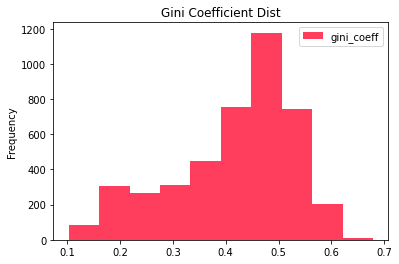

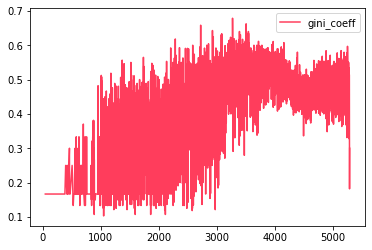

In [ ]:
# Plot Gini Coefficient for Given Vars (with values > 0) -- Deprecated

# Vars
Categorical = "rating"
DateTime = "datetime"
min_filter_out = 0.1
df_gini = gini(df, Categorical, DateTime)

# Filter out Values
df_gini = df_gini[df_gini['gini_coefficient'] > min_filter_out]

# Plot Hist & Line Graph
df_gini.plot.hist(color="#FF3D5C", title="Gini Coefficient Dist")
df_gini.plot(color="#FF3D5C")


All_Beauty's Dimensions: (371345, 5)
Appliances's Dimensions: (602777, 5)
Arts_Crafts_and_Sewing's Dimensions: (2875917, 5)
Automotive's Dimensions: (7990166, 5)
Books's Dimensions: (51311621, 5)
CDs_and_Vinyl's Dimensions: (4543369, 5)
Cell_Phones_and_Accessories's Dimensions: (10063255, 5)
Clothing_Shoes_and_Jewelry's Dimensions: (32292099, 5)
Digital_Music's Dimensions: (1584082, 5)
Electronics's Dimensions: (20994353, 5)
Gift_Cards's Dimensions: (147194, 5)
Grocery_and_Gourmet_Food's Dimensions: (5074160, 5)
Home_and_Kitchen's Dimensions: (21928568, 5)
Industrial_and_Scientific's Dimensions: (1758333, 5)
Kindle_Store's Dimensions: (5722988, 5)
Magazine_Subscriptions's Dimensions: (89689, 5)
Luxury_Beauty's Dimensions: (574628, 5)
Movies_and_TV's Dimensions: (8765568, 5)
Musical_Instruments's Dimensions: (1512530, 5)
Office_Products's Dimensions: (5581313, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Patio_Lawn_and_Garden's Dimensions: (5236058, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Pet_Supplies's Dimensions: (6542483, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Prime_Pantry's Dimensions: (471614, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Software's Dimensions: (459436, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Sports_and_Outdoors's Dimensions: (12980837, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Tools_and_Home_Improvement's Dimensions: (9015203, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Toys_and_Games's Dimensions: (8201231, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Video_Games's Dimensions: (2565349, 5)


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Fashion's Dimensions: (883636, 5)


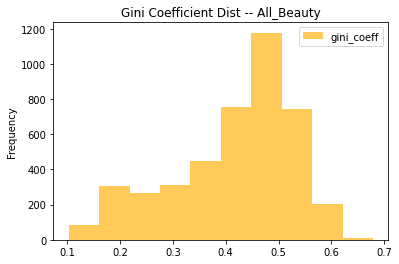

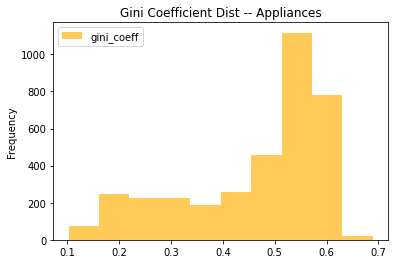

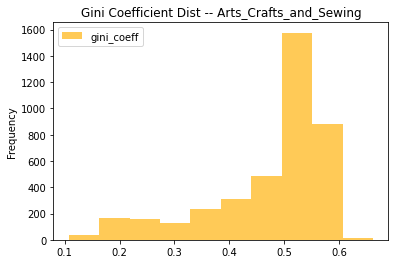

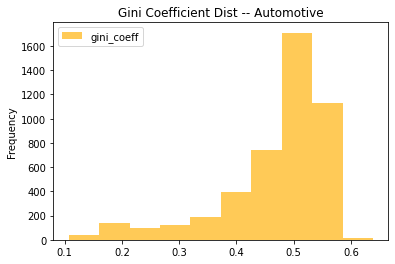

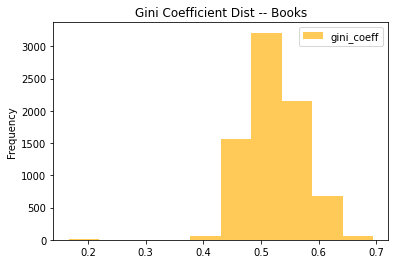

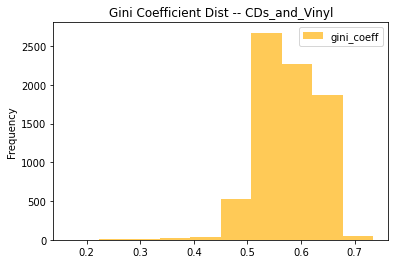

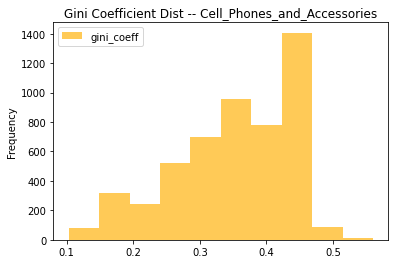

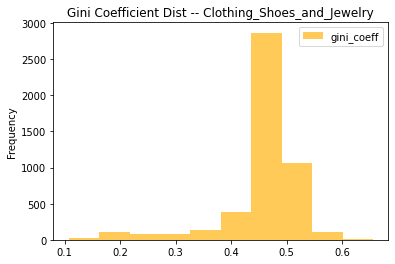

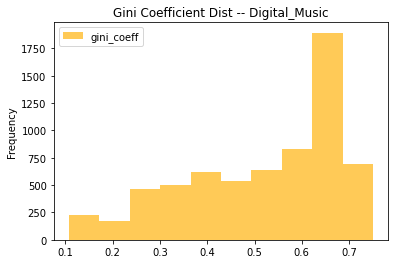

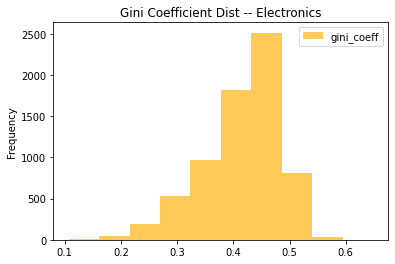

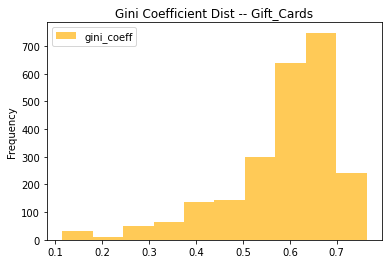

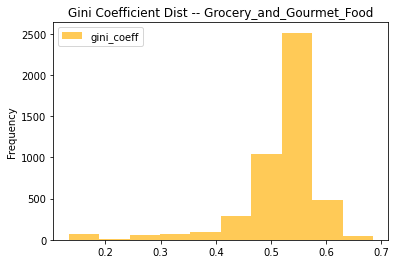

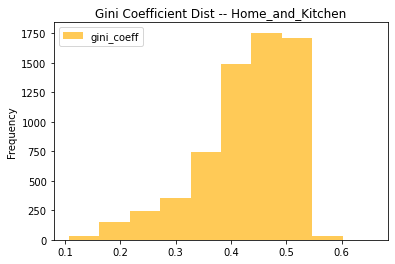

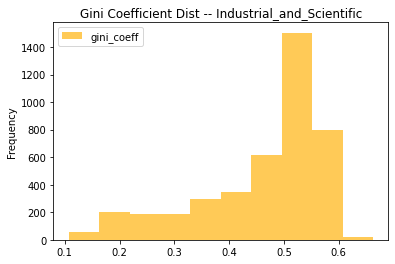

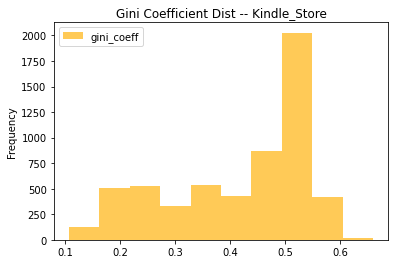

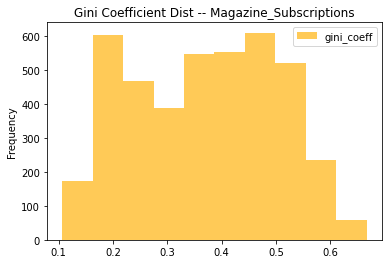

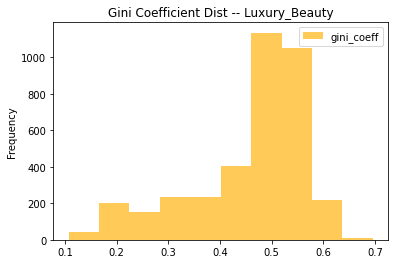

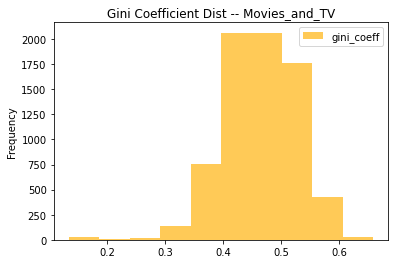

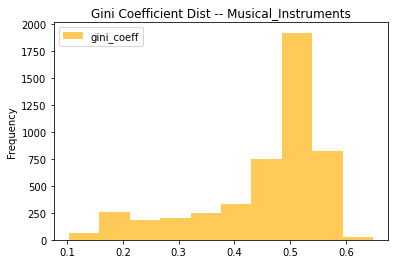

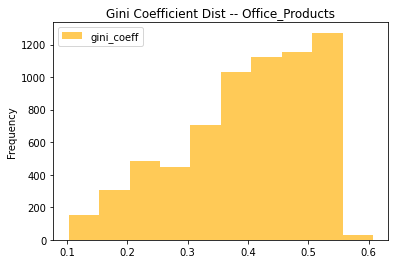

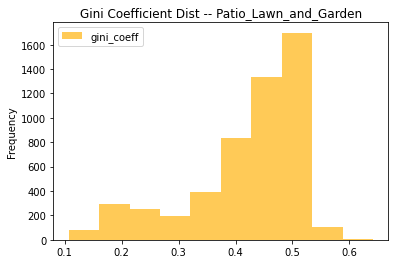

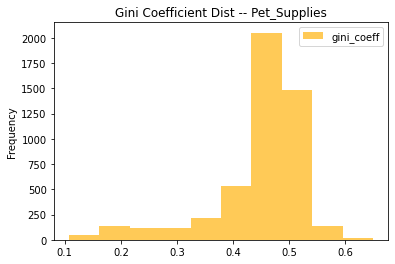

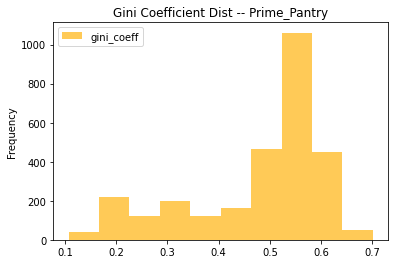

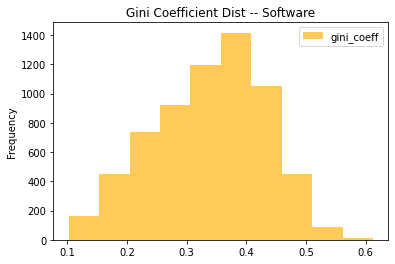

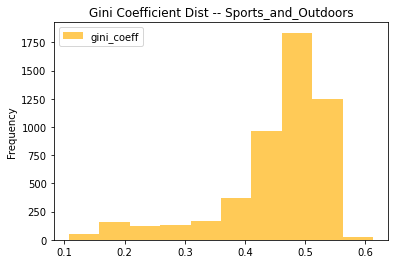

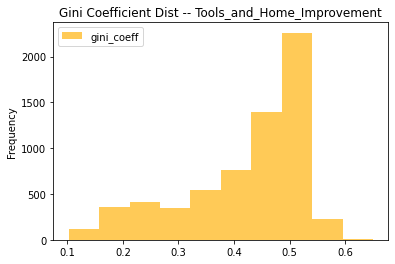

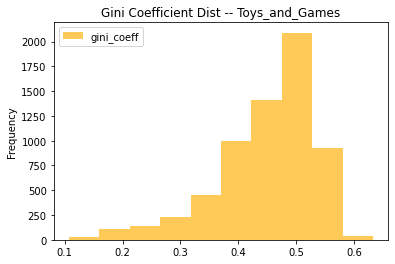

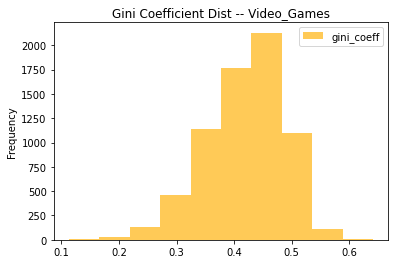

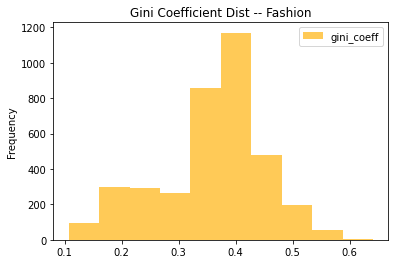

In [ ]:
# Get Hist Gini Distributions of Each Dataset

# Vars
Categorical = "rating"
DateTime = "datetime"


for csv_file in data_files:
    # Read in CSV & Clean Data
    #print(os.path.join(ckg_path, "Data", csv_file))
    csv_filepath = os.path.join(ckg_path, "Data", csv_file)
    df = read_and_clean(csv_filepath)

    # Calc Gini & Plot 
    df_gini = gini(df, Categorical, DateTime)
    df_gini = df_gini[df_gini['gini_coefficient'] > 0.1] #filtered dataset
    df_gini.plot.hist(color="#FFCA57", title=f"Gini Coefficient Dist -- {csv_file[:-4]}")

    print(f"{csv_file[:-4]}'s Dimensions: {df.shape}")

In [ ]:
# Computing the fourier transform using the numpy's fft function -- Referencing the "Data Quality(Stocks).ipynb"
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

gini_fft = np.fft.fft(df['gini_coefficient'])

print("Index of 10 highest values : ",list((np.absolute(gini_fft)**2).argsort()[-10:][::-1]))
print("10 Highest Values: ",np.sort((np.absolute(gini_fft)**2))[::-1][:10])

# removing the top amplitude
index_to_delete = list((np.absolute(gini_fft)**2).argsort()[-10:][::-1])
amplitude = np.delete(np.absolute(gini_fft)**2,index_to_delete) # real**2 + imaginary**2
amplitude_first_half = amplitude[:int(amplitude.shape[0]/2)]

#plot
amplitude_first_half/amplitude_first_half.shape[0]
fig = go.Figure(data=go.Scatter(x=np.arange(amplitude_first_half.shape[0])/amplitude.shape[0], y=amplitude_first_half))
fig.show()
